The SNR prediction is a time series and want to predict the value for the next step (or steps). 

<ol>There are two ways to do this
<li>Train a model for each series 
<li>Fit a model for all the series together? Which is better?
</ol>

This problem can be solved by creating a single model for each product. Although this is one of the possible solutions, it's not likely to be the best.

Here I will demonstrate how to train a single model to predict multiple time series at the same time. This technique usually creates powerful models that help teams win machine learning competitions and can be used in your project.

# Individual Models vs Big Model for Everything
In machine learning, more data usually means better predictions. If you try to create one model for each series, you will have some trouble with series that have little to no data. When you concatenate all your series into a single dataset, to train a single model, you are using a lot more data. This may help the model perform better!

Considering more than one series at a time, the model will be able to learn more subtle patterns that repeat across series. The product becomes a variable in our model.

First, let's import our basic tools:


In [111]:
# All imports
import os
import re
import numpy as np
np.set_printoptions(suppress=True)
from statistics import mean
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline
import pickle



## Preparing the Data
The data was obtained from the X60 Testbed.

Here we will try to forecast sales for 625 beams. Our dataset has records of SNR for 67 positions for each of the beam.

This means we have, originally, 625 time series with 67 data points each. Here I take only the beam_value and normalized SNR value for each position.

This is what the data looks like:

In [45]:
path = "../Lateral/"
workfile = "/workfile"
filenames = os.listdir(path)

p_files = {}
n_files = {}
pos = 0

regex = r"\[(.*?)\]"

def data_parser(path, num, axis):
    data = np.zeros((25,25))
    with open(path, "r") as file:
        for i in range(25):
            for j in range(25):
                line = file.readline().strip()
                match = round(mean([float(num) for num in re.findall(regex, line).pop().split(",")]),2)
                data[i,j] = match
        if axis == "n":
            n_files[pos] = data
        else:
            p_files[pos] = data

for filename in filenames:
    if re.search("-", filename):
        pos = int(re.findall(r'\d+', filename).pop())
        data_parser(path+filename+workfile,pos,"n")
    else:
        try:
            pos = int(re.findall(r'\d+', filename).pop())
        except:
            print(re.findall(r'\d+', filename))
        data_parser(path+filename+workfile,pos,"p")


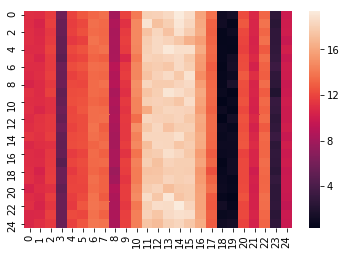

In [14]:
ax = sns.heatmap(p_files[3])

42500 rows × 3 columns

At this point, many data scientists would try to fit a model for each position. And while this can work well, we may have problems due to having only 68 data points for each model, which is really low!

As machine learning models tend to improve with more data, why not try to concatenate all the series and train a single model with much more data?

To make our lives easier, I decided to remove the letters from the beam names and position.

In [50]:
col = ["beam","position","SNR"]
pos_dir = pd.DataFrame(columns = col)
for key in sorted(n_files.keys(), reverse = True):
    for i in range(25):
        for j in range(25):
            pos_dir = pos_dir.append({'beam': 25*i+j, 'position':35-key, "SNR":n_files[key][i][j]}, ignore_index=True)
for key in sorted(p_files.keys()):
    for i in range(25):
        for j in range(25):
            pos_dir = pos_dir.append({'beam': 25*i+j, 'position':35+key, "SNR":p_files[key][i][j]}, ignore_index=True)
pos_dir.to_csv("Positive_x_directionMotion.csv")
pos_dir.head()

,beam,position,SNR
0,0.0,0.0,-0.48
1,1.0,0.0,-0.18
2,2.0,0.0,0.35
3,3.0,0.0,0.71
4,4.0,0.0,-0.84


In [135]:
col = ["beam","position","SNR"]
neg_dir = pd.DataFrame(columns = col)
for key in sorted(p_files.keys(), reverse = True):
    for i in range(25):
        for j in range(25):
            neg_dir = neg_dir.append({'beam': 25*i+j, 'position':32-key, "SNR":p_files[key][i][j]}, ignore_index=True)
for key in sorted(n_files.keys()):
    for i in range(25):
        for j in range(25):
            neg_dir = neg_dir.append({'beam': 25*i+j, 'position':32+key, "SNR":n_files[key][i][j]}, ignore_index=True)
neg_dir.to_csv("Negative_x_directionMotion.csv")
neg_dir.head()

,beam,position,SNR
0,0.0,0.0,-6.97
1,1.0,0.0,-9.33
2,2.0,0.0,-5.87
3,3.0,0.0,-8.68
4,4.0,0.0,-7.32


## Basic Feature Engineering
We need to have variables to send to our model and get the predictions. For now, besides the beam and the position, I will create two features that usually help a lot with time series: lags and differences.

Last Position SNRs: this is simply the value of SNR that a beam had in the previous position
Last Position Diff: the difference between the amount of SNR value in the previous Position and the position before it (pos-1 - pos-2)

In [136]:
melt2 = pos_dir.copy()
melt2['last_SNR'] = melt2.groupby(['beam'])['SNR'].shift()
melt2['Last_SNR_Diff'] = melt2.groupby(['beam'])['last_SNR'].diff()
melt2 = melt2.dropna()
melt2.head()

,beam,position,SNR,last_SNR,Last_SNR_Diff
1250,0.0,2.0,0.05,0.06,0.54
1251,1.0,2.0,0.41,-0.16,0.02
1252,2.0,2.0,1.90,-0.06,-0.41
1253,3.0,2.0,1.75,0.71,0.00
1254,4.0,2.0,0.66,-0.96,-0.12


In [137]:
nmelt2 = neg_dir.copy()
nmelt2['last_SNR'] = nmelt2.groupby(['beam'])['SNR'].shift()
nmelt2['Last_SNR_Diff'] = nmelt2.groupby(['beam'])['last_SNR'].diff()
nmelt2 = nmelt2.dropna()
nmelt2.head()

,beam,position,SNR,last_SNR,Last_SNR_Diff
1250,0.0,2.0,-3.50,-4.25,2.72
1251,1.0,2.0,-3.21,-4.77,4.56
1252,2.0,2.0,-5.24,-5.27,0.60
1253,3.0,2.0,-5.99,-5.63,3.05
1254,4.0,2.0,-5.77,-5.70,1.62


## Evaluating the Result

To know if our model is good we need to have an evaluation metric. A metric I really like for time series forecasting is the Root Mean Squared Error.

This is our well-known RMSE applied to the target and the prediction output.

It works as an approximation to the percentage error between our predictions and the target, which is a nice way to understand the errors our model is making.

In [138]:
def rmsle(ytrue, ypred):
    return np.sqrt(mean_squared_error(ytrue, ypred))

# Setting a Baseline and a Validation Split

Let's say that in real life your model will run every 2 seconds, so that early on 2 seconds the processor can make decisions based on the predictions for the next beam.

To see if our model will work in this scenario, position it has not seen before, I will use a sliding window validation. This means that we are going to simulate training the model in all the positions up to the one we want to predict, and evaluate our score in the new position.

And, to avoid having a very good model in a small amount of position simply due to luck, I will use every week from 45 to 68, repeating the process for one at a time, and compute the score.

As this is only a demonstration of the method, to keep it simple I am not separating a test set. In your projects, always keep some periods out of your validation to evaluate your model when you finish developing it. **This is very important**, and helps you be more secure about your model performing well when deployed.

To make sure the model is worth using I like to set a baseline score that it has to beat. In this case, a reasonably strong baseline is using the last position value of SNRs as a prediction for the SNR this location.

In [139]:
mean_error = []
for pos in range(50,67):
    train = melt2[melt2['position'] < pos]
    val = melt2[melt2['position'] == pos]
    
    p = val['last_SNR'].values
    
    error = rmsle(val['SNR'].values, p)
    print('Position %d - Error %.5f' % (pos, error))
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

Position 50 - Error 3.30580
Position 51 - Error 3.14443
Position 52 - Error 2.09586
Position 53 - Error 1.73193
Position 54 - Error 1.57264
Position 55 - Error 1.10413
Position 56 - Error 1.87308
Position 57 - Error 1.86182
Position 58 - Error 2.42727
Position 59 - Error 1.91671
Position 60 - Error 1.00620
Position 61 - Error 1.66492
Position 62 - Error 1.85033
Position 63 - Error 2.08899
Position 64 - Error 1.91763
Position 65 - Error 1.83398
Position 66 - Error 2.17259
Mean Error = 1.97461


In [140]:
mean_error = []
for pos in range(50,67):
    train = nmelt2[nmelt2['position'] < pos]
    val = nmelt2[nmelt2['position'] == pos]
    
    p = val['last_SNR'].values
    
    error = rmsle(val['SNR'].values, p)
    print('Position %d - Error %.5f' % (pos, error))
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

Position 50 - Error 2.80436
Position 51 - Error 1.53820
Position 52 - Error 0.89366
Position 53 - Error 2.01121
Position 54 - Error 1.99545
Position 55 - Error 1.07305
Position 56 - Error 1.57265
Position 57 - Error 1.59029
Position 58 - Error 1.40740
Position 59 - Error 1.45682
Position 60 - Error 0.77727
Position 61 - Error 0.93108
Position 62 - Error 2.19375
Position 63 - Error 2.43166
Position 64 - Error 1.83700
Position 65 - Error 1.67926
Position 66 - Error 2.09748
Mean Error = 1.66415


Now we know that our model has to have a better error than about XX. This would be approximately XX% error in each prediction, which seems huge! But is it really?

If we look at the distribution of SNR in the dataset, we see that a lot of items SNR is very little amounts. So we should expect the error to look "high".

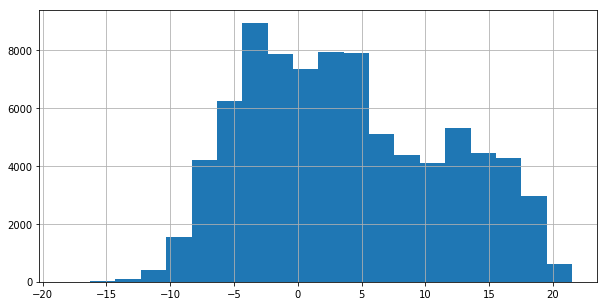

In [141]:
melt2['SNR'].hist(bins=20, figsize=(10,5))

# Creating the Model
Now that we have a baseline, let's try to beat it!

As a first model, let's train a Random Forest. Besides being a strong model with structured data (like the one we have), we usually can already get a very good result by just setting a high number of trees.

I usually prefer a Random Forest is a very good model to use in a lazy day. You only set the number of trees to the maximum your computer can run and get a good model (hopefully).

I will keep the position as a feature although our model will have never seen the new position value. It may be that after position 45, for example, we have more SNRs for a beam. This type of effect can be captured by the model.

As decision trees can handle categorical features well even in ordinal encoding, I left them in this format.



In [129]:
mean_error = []
pos_predicted = None
pos_tested = None
for pos in range():
    train = melt2[melt2['position'] < pos]
    val = melt2[melt2['position'] == pos]
    
    xtr, xts = train.drop(['SNR'], axis=1), val.drop(['SNR'], axis=1)
    ytr, yts = train['SNR'].values, val['SNR'].values
    
    mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdl.fit(xtr, ytr)
    filename = 'LeftToRight.sav'
    pickle.dump(mdl, open(filename, 'wb'))
     
    p = mdl.predict(xts)
    
    pos_predicted = p
    if pos == 19:
        pos_tested = yts
    
    error = rmsle(yts, p)
    print('pos %d - Error %.5f' % (pos, error))
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

pos 20 - Error 1.91409
Mean Error = 1.91409


In [130]:
mean_error = []
neg_predicted = None
neg_tested = None

for pos in range(48,49):
    train = nmelt2[nmelt2['position'] != pos]
    val = nmelt2[nmelt2['position'] == pos]
    
    xtr, xts = train.drop(['SNR'], axis=1), val.drop(['SNR'], axis=1)
    ytr, yts = train['SNR'].values, val['SNR'].values
    
    mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdl.fit(xtr, ytr)
    filename = 'RightToLeft.sav'
    pickle.dump(mdl, open(filename, 'wb'))
     
    p = mdl.predict(xts)
    
    neg_predicted = p
    if pos == 47:
        neg_tested = yts
    
    error = rmsle(yts, p)
    print('pos %d - Error %.5f' % (pos, error))
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

pos 48 - Error 2.82334
Mean Error = 2.82334


In [ ]:
loaded_model = pickle.load(open(RightToLeft, 'rb'))
result = loaded_model.predict(xtr, ytr)

In [132]:
sns.heatmap(neg_tested.reshape(25,25))

AttributeError: 'NoneType' object has no attribute 'reshape'

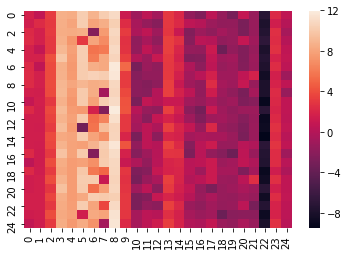

In [133]:
sns.heatmap(neg_predicted.reshape(25,25))

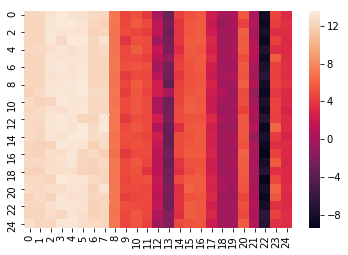

In [134]:
sns.heatmap(pos_predicted.reshape(25,25))